In [1]:
from __future__ import division
import sympy as sym
from sympy import sqrt, cos, sin, exp, pi, S, diff, Matrix, Derivative, I

In [2]:
sym.init_printing()

In [3]:
x = sym.symbols('x0:%d'%6)
y = sym.symbols('y0:%d'%6)
u = sym.symbols('u0:%d'%6)
v = sym.symbols('v0:%d'%6)
c, m, omega, a = sym.symbols('c m omega a', real=True)
kx, ky = sym.symbols('kx ky', real=True)
kp, km = sym.symbols('km kp', real=True)

The unit cell looks like

        5----O
       /      \
      /        \
     4          1
      \        /
       \      /
        3----2


## 1. Equations of motion

The kinetic energy has the form

In [4]:
def T(i):
    return S(1)/6*m*(u[i]**2 + v[i]**2)

In [5]:
cx = c*cos(pi/3)
cy = c*sin(pi/3)

The potential energy has the form

In [6]:
V0 = S(1)/2*cx*(x[1] - x[0])**2 + S(1)/2*c*(x[5] - x[0])**2 +  S(1)/2*cy*(y[1] - y[0])**2
V1 = S(1)/2*cx*(x[2] - x[1])**2 + S(1)/2*cx*(x[0] - x[1])**2 +  S(1)/2*cy*(y[2] - y[1])**2 + S(1)/2*cy*(y[0] - y[1])**2
V2 = S(1)/2*cx*(x[1] - x[2])**2 + S(1)/2*c*(x[3] - x[2])**2 +  S(1)/2*cy*(y[1] - y[2])**2
V3 =  S(1)/2*cx*(x[4] - x[3])**2 + S(1)/2*c*(x[2] - x[3])**2 +  S(1)/2*cy*(y[4] - y[3])**2
V4 = S(1)/2*cx*(x[3] - x[4])**2 + S(1)/2*cx*(x[5] - x[4])**2 +  S(1)/2*cy*(y[3] - y[4])**2 + S(1)/2*cy*(y[5] - y[4])**2
V5 =  S(1)/2*cx*(x[4] - x[5])**2 + S(1)/2*c*(x[5] - x[0])**2 +  S(1)/2*cy*(y[4] - y[5])**2

In [7]:
V = [V0, V1, V2, V3, V4, V5]

In [8]:
L = sum(T(i) - V[i]/2 for i in range(6)).simplify()

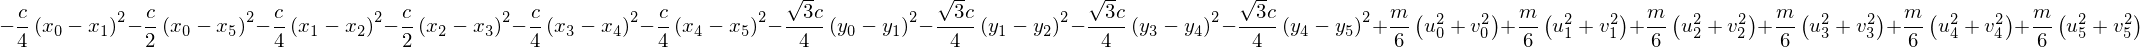

In [9]:
L

In [10]:
coords = reduce(list.__add__, [[x[i], y[i]] for i in range(6)])

In [11]:
vars = reduce(list.__add__, [[u[i], v[i]] for i in range(6)])

In [12]:
vars

In [13]:
K = Matrix(12, 12, lambda i,j: diff(L, coords[i], coords[j]) )

In [14]:
M = Matrix(12, 12, lambda i,j: diff(diff(L, vars[i]).subs(vars[i], -omega**2*coords[i])
                                    , coords[j]) )

And the corresponding matrices are

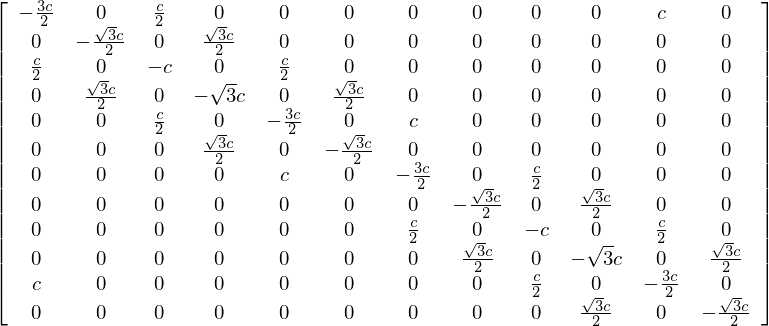

In [15]:
K

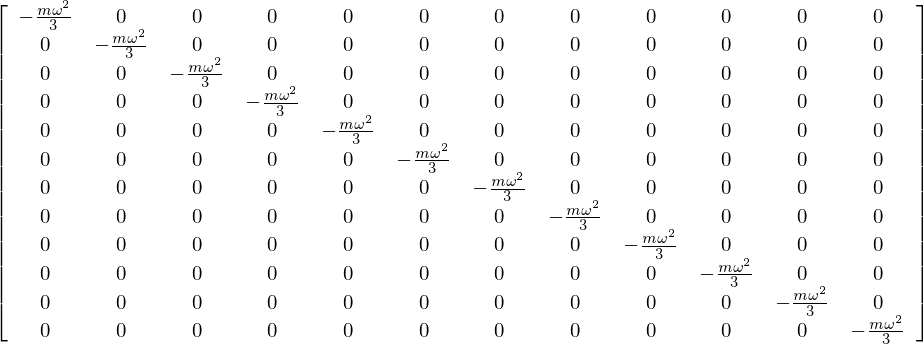

In [16]:
M

In this case we don't need to make the row/column operations
on the mass matrix, since it is an identity matrix (times a
constant).

Row 1 and 2 by $\exp(i k_x a)$

In [17]:
phase_x = [a*cos(pi/3), a, a*cos(pi/3), -a*cos(pi/3), -a, -a*cos(pi/3)]
phase_y = [-a*sin(pi/3), 0, a*sin(pi/3), a*sin(pi/3), 0, -a*sin(pi/3)]

In [18]:
M1 = Matrix(12, 12, lambda i,j: exp(-I*kx*phase_x[i//2])*exp(-I*ky*phase_y[i//2]) if i==j else 0)

In [19]:
K2 = M1*K*M1.conjugate()

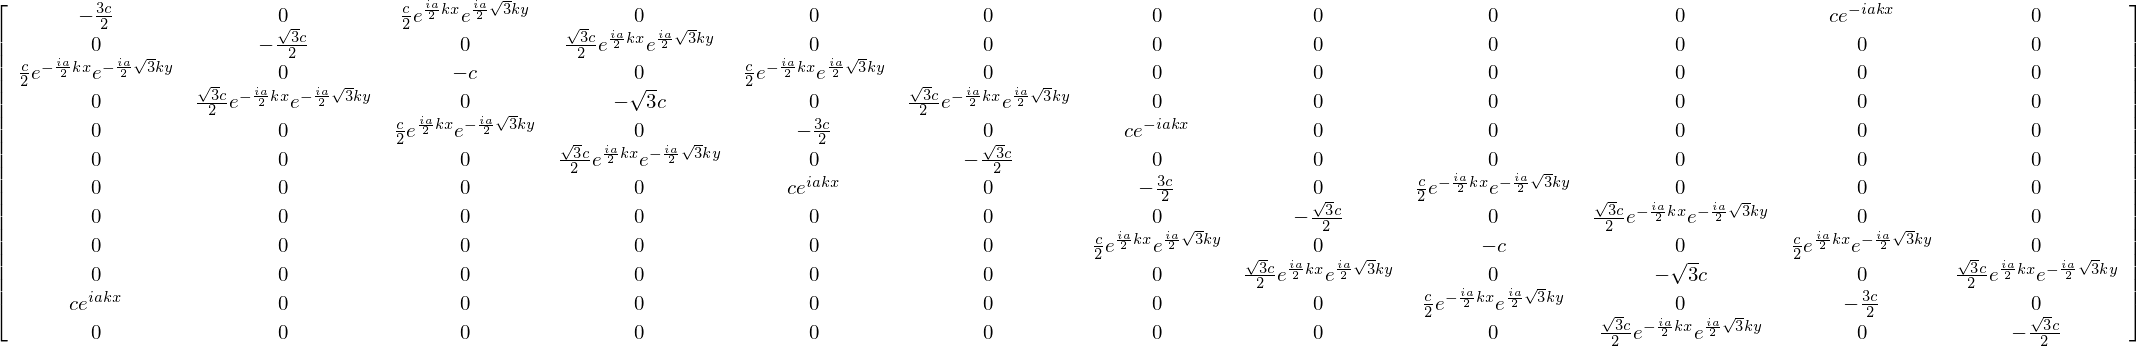

In [20]:
K2

rows 2, 6 added to 10; 3,7 added to 11; 0,4 added to 8; and 3,1 added to 9

In [21]:
S1 = sym.zeros(12, 12)
for i in range(12):
    for j in range(12):
        if  i==j or (i==8 and (j==0 or j==4)) or (i==9 and (j==1 or j==5)) or\
         (i==10 and (j==2 or j==6) or (i==11 and (j==3 or j==7))):
            S1[i, j] = 1

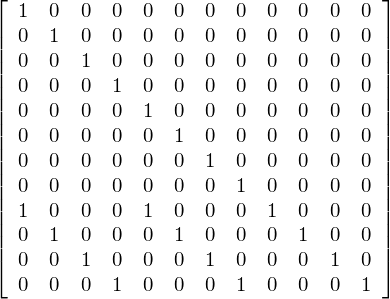

In [22]:
S1

In [23]:
K3 = S1*K2*S1.transpose()

In [24]:
M2 = S1*M*S1.transpose()

Delete rows 0 to 7

In [25]:
D = sym.zeros(4, 12)
for i in range(4):
    D[i, i+8] = 1

In [26]:
def rewrite_cos(expr):
    return expr.rewrite(cos)
K4 = D*K3*D.transpose()
K4 = K4.applyfunc(rewrite_cos).expand()

In [27]:
M3 = D*M2*D.transpose()

We don't need c/m since they can be a factor to divide the eigenvalues

In [28]:
Keff = (M3.inv()*K4)*m*omega**2/c
Keff = sym.trigsimp(Keff)

We can make some substitutions

In [29]:
skp, skm, ckp, ckm, ckx, skx = sym.symbols('skp skm ckp ckm ckx skx')

In [30]:
Keff2 = Keff.subs([(a*(kx - sqrt(3)*ky)/2, -kp),
                   (a*(kx + sqrt(3)*ky)/2, km)])
Keff2 = Keff2.subs([(a, 1),
                    (sin(kp), skp),
                    (sin(km), skm),
                    (cos(kp), ckp),
                    (cos(km), ckm),
                    (cos(kx), ckx),
                    (sin(kx), skx)])